<a href="https://colab.research.google.com/github/khushidubeyokok/PyTorch/blob/main/04_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom datasets - get your own dataasets into pytorch

## import pytorch and set up device agnostic code

In [92]:
import torch
from torch import nn

In [93]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Get data - our dataset is a subset of Food101 dataset
- Food101 datset starts with 101 classes and over 1000images per class (750 training and 250 testing)
- our dataset starts with onyl 3 classes of food and only 10% of  the images (~75 training and ~25 testing)

In [94]:
import requests
import zipfile
from pathlib import Path

In [95]:
# setup path to a data folder
data_path=Path('data/')
image_path=data_path/"pizza_steak_sushi"

#if the image folder doesnt exist download it and prepare it
if image_path.is_dir():
  print(f"{image_path}exists,skipping download")
else:
  print(f"{image_path}does not exist, creating...")
  image_path.mkdir(parents=True,exist_ok=True)

data/pizza_steak_sushiexists,skipping download


In [96]:
#download data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

#unzipping zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)

## Data preparation and data exploration - Becoming one with the data

In [97]:
import os
def explore_dir(path):
  for dirpath,dirname,filename in os.walk(path):
    print(f"there are {len(dirname)} directories and {len(filename)} images in {dirpath}")

In [98]:
explore_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak


In [99]:
# setup train and test dir
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualising image

1. get all image paths
2. open random image using random.choice()
3. get image labels using pathlib.Path.parent.stem()
4. open the image using python's PIL
5. show the image and print metadata

Images [PosixPath('data/pizza_steak_sushi/train/sushi/821108.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/1957449.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/1552504.jpg')]
random_image_path : data/pizza_steak_sushi/train/sushi/424994.jpg
image class : sushi
image height : 382
image width: 512


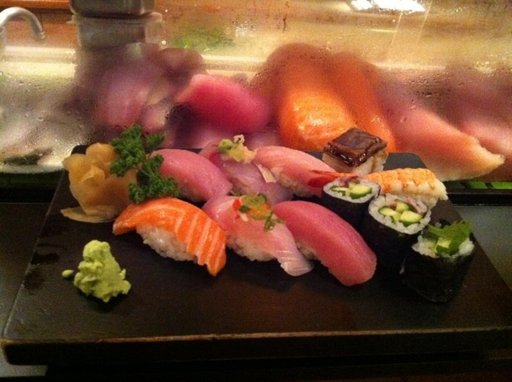

In [100]:
import random
from PIL import Image
random.seed(42)

# Get all image paths
image_path_list=list(image_path.glob('*/*/*.jpg'))
print(f"Images {image_path_list[:3]}")

# pick a random image
random_image_path=random.choice(image_path_list)

#get image class - image class is the name of the directory where the image is stored
image_class = random_image_path.parent.stem

#open the image
img = Image.open(random_image_path)

#print metadata
print(f"random_image_path : {random_image_path}")
print(f"image class : {image_class}")
print(f"image height : {img.height}")
print(f"image width: {img.width}")
img

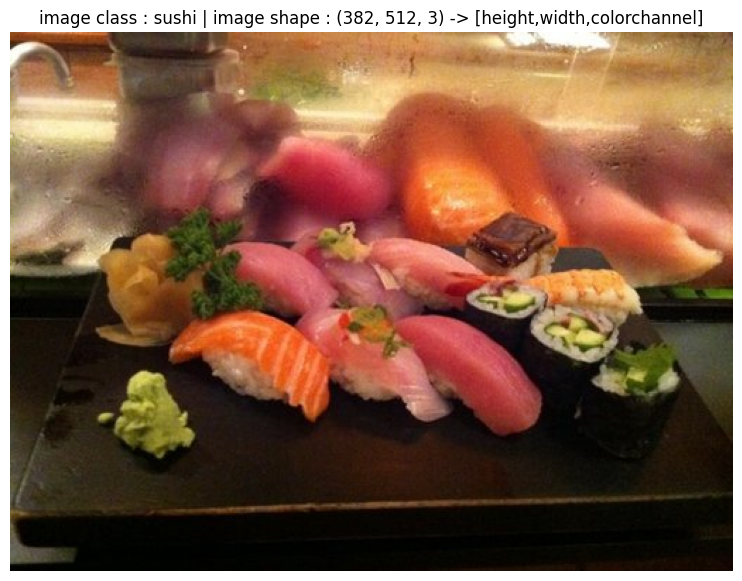

In [101]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"image class : {image_class} | image shape : {img_as_array.shape} -> [height,width,colorchannel]")
plt.axis(False);

## Transforming data

1. turn data into tensors
2. turn tensors into `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`, we will call these are 'dataset' and 'dataloader'

In [102]:
from torch.utils.data import dataloader
from torchvision import datasets,transforms

In [103]:
# transform images

data_transform=transforms.Compose([
    # resize image
    transforms.Resize(size=(64,64)),
    #flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    #turn into tensor
    transforms.ToTensor()
    ])

In [104]:
data_transform(img).shape, img_as_array.shape

(torch.Size([3, 64, 64]), (382, 512, 3))

In [105]:
def plot_transormed(image_path,transform,n=3,seed=None):
  """ selects random images from a path of images and
  loads/transforms then plots original vs transformed """

  if seed:
    random.seed(seed)
  random_image_path=random.sample(image_path,k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nsize:{f.size}")
      ax[0].axis(False)

      transformed=transform(f).permute(1,2,0)
      ax[1].imshow(transformed)
      ax[1].set_title(f"transformed\nsize:{transformed.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class:{image_path.parent.stem}",fontsize=16)

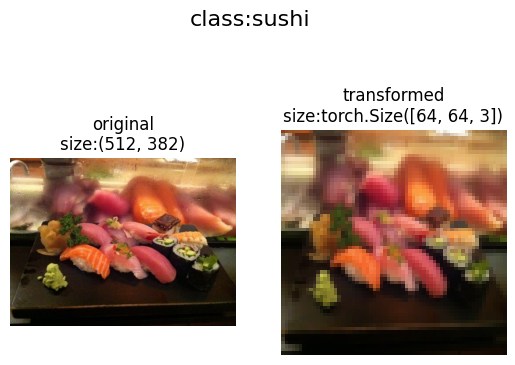

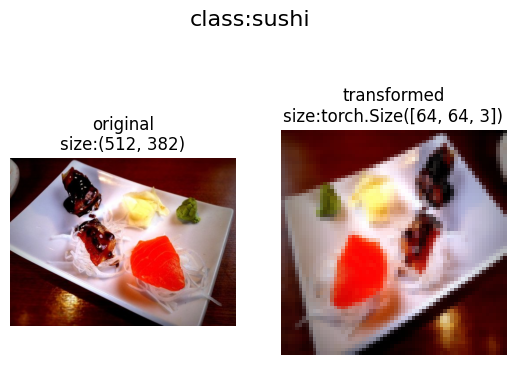

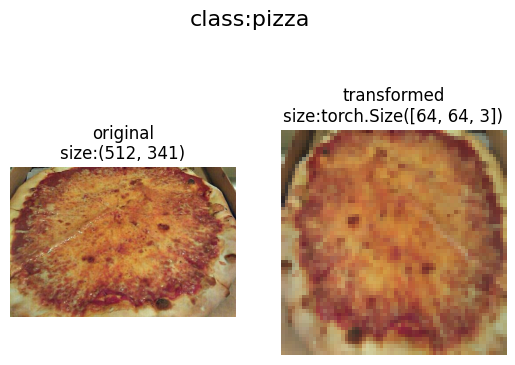

In [106]:
plot_transormed(image_path=image_path_list,transform=data_transform,n=3,seed=42)

## Option 1 : loading our image using `ImageFolder`
- We can load image classification data using `torchvision.datasets.ImageFolder`

In [107]:
# use ImageFolder to create dataset(s)
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform,target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [108]:
# get class names as list
class_names=train_data.classes
print(f"class names list: {class_names}, class names as dictionary: {train_data.class_to_idx}")

class names list: ['pizza', 'steak', 'sushi'], class names as dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


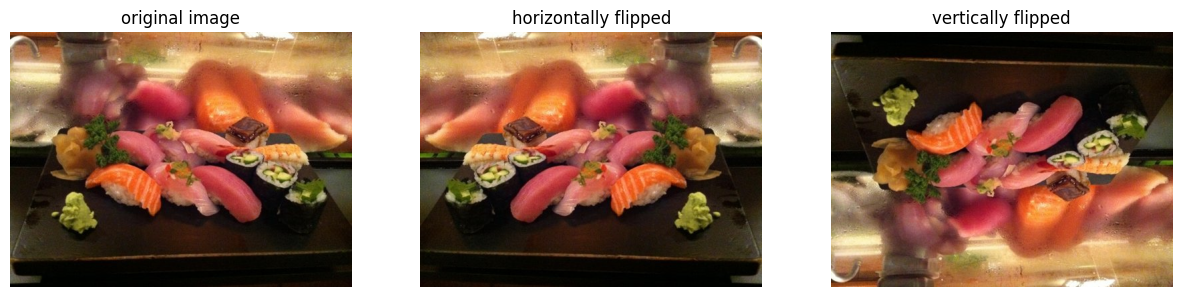

In [109]:
img=Image.open(random_image_path)
horizontal_flip=transforms.RandomHorizontalFlip(p=1)
vertical_flip=transforms.RandomVerticalFlip(p=1)
horizontal_flipped_image=horizontal_flip(img)
vertical_flipped_image=vertical_flip(img)
# plt.figure(figsize=(15,15))
# plt.subplot(1,3,1)
# plt.title("original image")
# plt.imshow(img)
# plt.subplot(1,3,2)
# plt.title("horizontally flipped")
# plt.imshow(horizontal_flipped_image)
# plt.subplot(1,3,3)
# plt.title("vertically flipped")
# plt.imshow(vertical_flipped_image)

fig,ax=plt.subplots(1,3)
ax[0].imshow(img)
ax[0].set_title("original image")
ax[0].axis(False)
ax[1].imshow(horizontal_flipped_image)
ax[1].set_title("horizontally flipped")
ax[1].axis(False)
ax[2].imshow(vertical_flipped_image)
ax[2].set_title("vertically flipped")
ax[2].axis(False)
fig.set_size_inches(15,15)

In [110]:
# get class name and image
img,label=train_data[0][0],train_data[0][1]
print(f"image tensor : {img[:1]}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label : {label}")
print(f"label datatype: {type(label)}")

image tensor : tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]]])
image shape: torch.Size([3, 64, 64])
image datatype: torch.float32
image label : 0
label datatype: <class 'int'>


(-0.5, 63.5, 63.5, -0.5)

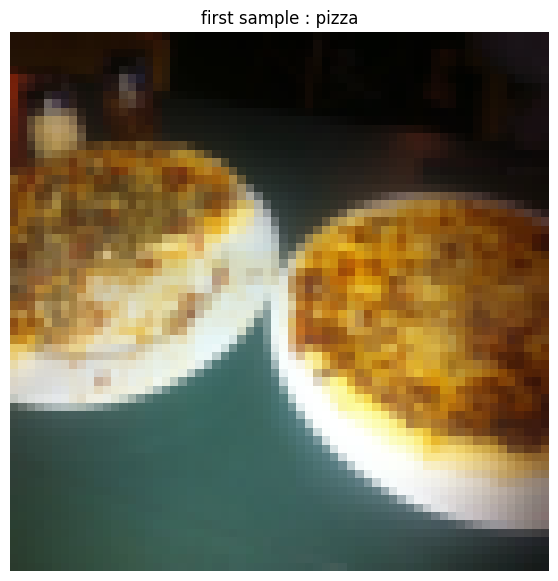

In [111]:
permuted_img=img.permute(1,2,0)
plt.figure(figsize=(7,7))
plt.imshow(permuted_img)
plt.title(f"first sample : {class_names[label]}")
plt.axis(False)

### Turn datasets into dataloader

In [112]:
import os
from torch.utils.data import DataLoader
os.cpu_count()

2

In [113]:
train_dataloader=DataLoader(dataset=train_data,batch_size=1,num_workers=os.cpu_count(),shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=1,num_workers=os.cpu_count(),shuffle=True)

len(train_dataloader),len(test_dataloader)

(225, 75)

In [114]:
len(train_data),len(test_data)

(225, 75)

In [115]:
img,label=next(iter(train_dataloader))
print(f"image tensor : {img[:1]}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label : {label}")
print(f"label datatype: {label.shape}")

image tensor : tensor([[[[0.4706, 0.3647, 0.3451,  ..., 0.0039, 0.0039, 0.0039],
          [0.4588, 0.4314, 0.4314,  ..., 0.0039, 0.0039, 0.0039],
          [0.4235, 0.4314, 0.4353,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.3373, 0.3529, 0.3490],
          [0.0471, 0.0471, 0.0431,  ..., 0.1882, 0.2039, 0.2235],
          [0.0392, 0.0392, 0.0431,  ..., 0.0706, 0.0824, 0.1098]],

         [[0.4863, 0.4078, 0.3922,  ..., 0.0039, 0.0039, 0.0039],
          [0.5569, 0.5412, 0.5451,  ..., 0.0039, 0.0039, 0.0039],
          [0.5294, 0.5529, 0.5647,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0314, 0.0314, 0.0314,  ..., 0.3804, 0.3961, 0.4039],
          [0.0353, 0.0353, 0.0353,  ..., 0.2157, 0.2353, 0.2627],
          [0.0314, 0.0314, 0.0314,  ..., 0.0784, 0.0980, 0.1137]],

         [[0.5333, 0.4431, 0.4235,  ..., 0.0039, 0.0039, 0.0039],
          [0.5686, 0.5529, 0.5569,  ..., 0.0039, 0.0039, 0.0039],
          [0.5608, 0.5725, 

## Option 2 : loading image data with a custom dataset
- want to be able to get images from files
- want to be able to get class names from the dataset
- want to be able to get classes as dictionary from the dataset

In [116]:
import os
import torch
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [117]:
# instance of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names
- Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
- Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
- Turn the class names into a dictionary of numerical labels, one for each class.


In [118]:
# setup path for target directory
target_dir=train_dir
target_dir

PosixPath('data/pizza_steak_sushi/train')

In [119]:
# get class names from target directory
class_names_found=sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

['pizza', 'steak', 'sushi']

In [120]:
def find_classes(directory:str)->Tuple[list[str],dict[str,int]]:
  """ finds the class folder name in a target directory"""
  #1. class names by scanning the target directory
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  #2. raise an error if class names could not be found
  if not classes:
    raise FileNoFoundError(f"could not find any classes in {directory}..please check file structure")
  #3. create a dictionary of index labels
  class_to_idx={classname:i for i,classname in enumerate(classes)}

  return classes, class_to_idx

In [121]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a custom dataset to replicate `ImageFolder`
1. Subclass torch.utils.data.Dataset.
2. Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
3. Create several attributes for
- paths (the paths of our target images)
- transform (the transforms we might like to use, this can be None)
-  classes : a list of target classes
- class_to_idx (from our find_classes() function), a dict of classes mapped to labels
4. Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
5. Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
6. Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [122]:
# 0.create a custom dataset
from torch.utils.data import Dataset

# 1.create a class [imagefolder] whihc subclasses torch.utils.data.Dataset
class CustomImageFolder(Dataset):
  # 2.initilaise our custom dataset
  def __init__(self,target_dir,transform):
    # 3.create class attributes:path,transform,classes,clas_to_idx
    self.paths=list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform=transform
    self.classes,self.class_to_idx=find_classes(target_dir)

  # 4.create a function to load images
  def load_image(self,index):
    """ opens an image via path an returns it"""
    image_path=self.paths[index]
    return Image.open(image_path)

  # 5.overwrite len function
  def __len__(self):
    """returns number of samples"""
    return len(self.paths)

  #6. overwrite get_item()
  def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:
    img=self.load_image(index)
    class_name=self.paths[index].parent.name
    class_idx=self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img),class_idx
    else:
      return img,class_idx

In [123]:
train_data_custom=CustomImageFolder(train_dir,data_transform)
test_data_custom=CustomImageFolder(test_dir,data_transform)

train_data_custom,test_data_custom

(<__main__.CustomImageFolder at 0x7c49c3b0ae00>,
 <__main__.CustomImageFolder at 0x7c49c3b0b910>)

In [124]:
len(train_data),len(train_data_custom)

(225, 225)

In [125]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [126]:
train_data_custom[0][0]

tensor([[[0.0275, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0510, 0.0588,  ..., 0.0000, 0.0000, 0.0000],
         [0.0627, 0.0667, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8471, 0.8510, 0.8549,  ..., 0.0667, 0.0706, 0.0667],
         [0.8667, 0.8667, 0.8627,  ..., 0.0706, 0.0706, 0.0706],
         [0.8706, 0.8784, 0.8784,  ..., 0.0784, 0.0745, 0.0706]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0353, 0.0314, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0392, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8118, 0.8078, 0.8078,  ..., 0.0706, 0.0706, 0.0667],
         [0.8235, 0.8196, 0.8196,  ..., 0.0745, 0.0667, 0.0667],
         [0.8275, 0.8314, 0.8392,  ..., 0.0706, 0.0627, 0.0627]],

        [[0.0157, 0.0157, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0196, 0.0235,  ..., 0.0000, 0.0000, 0.

In [127]:
# check for equality of original ImmageFolder and our custom dataset class
print(train_data.classes==train_data_custom.classes)
print(test_data.classes==test_data_custom.classes)

True
True


### Create a function to display random images
- Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.
- To prevent the display getting out of hand, we'll cap n at 10 images.
- Set the random seed for reproducible plots (if seed is set).
- Get a list of random sample indexes (we can use Python's random.sample() for this) to plot.
- Setup a matplotlib plot.
- Loop through the random sample indexes found in step 4 and plot them with matplotlib.
- Make sure the sample images are of shape HWC (height, width, color channels) so we can plot them.

In [128]:
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str],
                          n:int=10,
                          seed:int=None,
                          display_shape:bool=True):
  # adjust size and remove displaying shape if n is high
  if n>10:
    n=10
    display_shape=False
    print("for display purposes n can be not more than ten!")

  if seed:
    random.seed(seed)

  #get random sample index
  random_sample_idx=random.sample(range(len(dataset)),k=n)

  plt.figure(figsize=(16,8))
  #loop through random indexes and plt them through matplotlib
  for i,idx in enumerate(random_sample_idx):
    targ_img,targ_label=dataset[idx][0],dataset[idx][1]

    #adjust to HWC
    targ_img_adjust=targ_img.permute(1,2,0)

    plt.subplot(1,n,i+1)
    plt.imshow(targ_img_adjust)
    title=classes[targ_label]
    plt.axis(False)
    if display_shape:
      title=title+ f"\n:{targ_img_adjust.shape}"
    plt.title(title,fontsize=7)


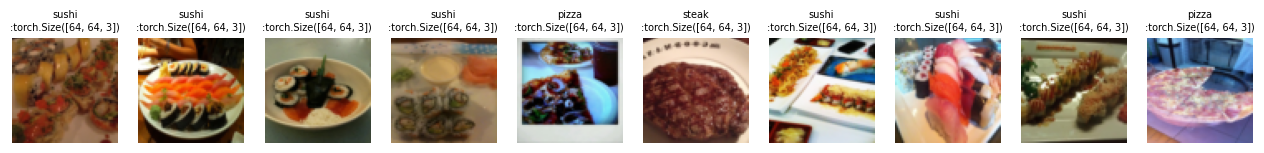

In [129]:
display_random_images(train_data_custom,train_data_custom.classes,10,555)

### Turn custom loaded images into dataloader

In [130]:
from torch.utils.data import DataLoader
train_dataloader_custom=DataLoader(train_data_custom,batch_size=32,num_workers=0,shuffle=True)
test_dataloader_custom=DataLoader(test_data_custom,batch_size=32,num_workers=0,shuffle=False)

In [131]:
train_data_custom,test_dataloader_custom

(<__main__.CustomImageFolder at 0x7c49c3b0ae00>,
 <torch.utils.data.dataloader.DataLoader at 0x7c49a6c4f0d0>)

In [132]:
img_custom,label_custom=next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Other forms of transform (data augmentation)

*   Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).




In [133]:
# Lets try torchvision.transforms.trivialaugment
from torchvision import transforms

train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [134]:
image_path_list=list(image_path.glob('*/*/*.jpg'))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/sushi/821108.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1957449.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1552504.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1575445.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/773725.jpg')]

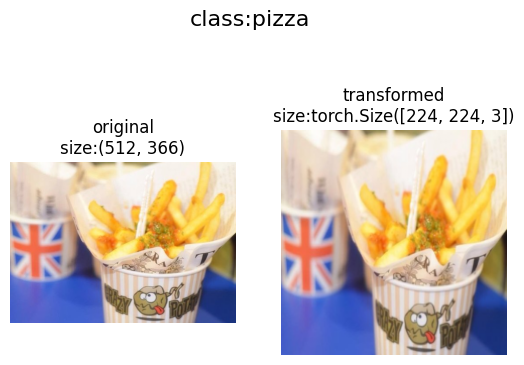

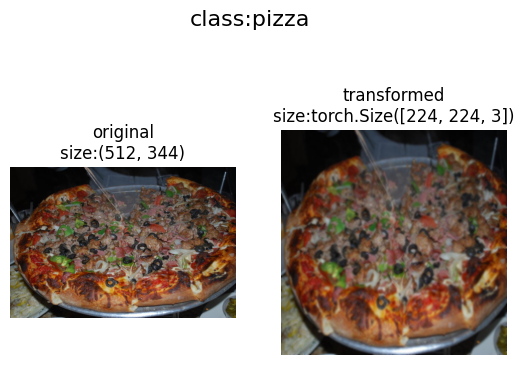

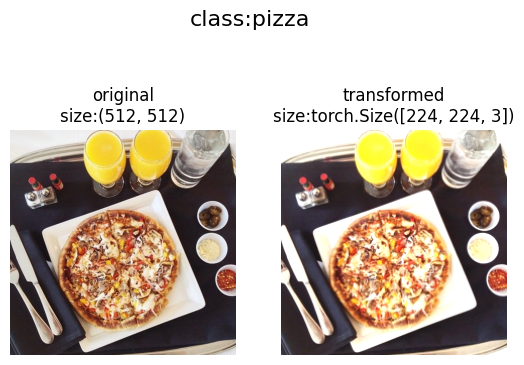

In [135]:
#plot transformed images
plot_transormed(image_path_list,train_transform,n=3)

## Model_0: Tiny VGG without augmentation

### Loading data and creating simple transforms

In [136]:
simple_transform=transforms.Compose([transforms.Resize(size=(64,64)),transforms.ToTensor()])

In [137]:
# load images as dataset
from torchvision.datasets import ImageFolder
train_data_simple=ImageFolder(root=train_dir,transform=simple_transform,target_transform=None)
test_data_simple=ImageFolder(root=test_dir,transform=simple_transform,target_transform=None)

In [138]:
# turn dataset into dataloader
from torch.utils.data import DataLoader
import os
train_dataloader_simple=DataLoader(dataset=train_data_simple,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_dataloader_simple=DataLoader(dataset=test_data_simple,batch_size=32,shuffle=False,num_workers=os.cpu_count())

### Create TinyVGG model class

In [139]:
class TinyVGG(nn.Module):
  def __init__(self,input,hidden_units,output):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block3=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(nn.Flatten(),
                                  nn.Linear(in_features=hidden_units*4*4,out_features=output))

  def forward(self,x):
    x=self.block1(x)
    #print(x.shape)
    x=self.block2(x)
    #print(x.shape)
    x=self.block3(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x

In [140]:
model_0=TinyVGG(input=3,hidden_units=60,output=len(class_names)).to(device) #input is number of color channels in our data
model_0

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=960, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image


In [141]:
# get a simple image batch
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [142]:
# try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.0330, -0.0326, -0.0090],
        [ 0.0332, -0.0326, -0.0090],
        [ 0.0324, -0.0323, -0.0073],
        [ 0.0331, -0.0327, -0.0089],
        [ 0.0330, -0.0321, -0.0083],
        [ 0.0326, -0.0326, -0.0084],
        [ 0.0329, -0.0326, -0.0085],
        [ 0.0327, -0.0327, -0.0089],
        [ 0.0330, -0.0330, -0.0083],
        [ 0.0328, -0.0325, -0.0072],
        [ 0.0326, -0.0325, -0.0082],
        [ 0.0326, -0.0326, -0.0077],
        [ 0.0327, -0.0330, -0.0081],
        [ 0.0330, -0.0330, -0.0091],
        [ 0.0332, -0.0326, -0.0085],
        [ 0.0330, -0.0326, -0.0084],
        [ 0.0326, -0.0329, -0.0079],
        [ 0.0324, -0.0338, -0.0081],
        [ 0.0326, -0.0328, -0.0077],
        [ 0.0333, -0.0322, -0.0085],
        [ 0.0328, -0.0321, -0.0079],
        [ 0.0327, -0.0324, -0.0070],
        [ 0.0326, -0.0321, -0.0075],
        [ 0.0329, -0.0332, -0.0091],
        [ 0.0328, -0.0332, -0.0084],
        [ 0.0329, -0.0320, -0.0083],
        [ 0.0333, -0.0325, -0.0094],
 

### Using `torchinfo`to get summary of the model

In [143]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 60, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 60, 62, 62]           1,680
│    └─ReLU: 2-2                         [1, 60, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 60, 60, 60]           32,460
│    └─ReLU: 2-4                         [1, 60, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 60, 30, 30]           --
├─Sequential: 1-2                        [1, 60, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 60, 28, 28]           32,460
│    └─ReLU: 2-7                         [1, 60, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 60, 26, 26]           32,460
│    └─ReLU: 2-9                         [1, 60, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 60, 13, 13]           --


### Create training and testing functions

In [144]:
def train_model(model,dataloader,loss_function,optimiser):
  model=model.to(device)
  model.train()
  train_loss=0
  train_acc=0
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)
    y_pred=model(X) #output model logits
    loss=loss_function(y_pred,y)
    train_loss+=loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    #calculate accuracy
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)

  return train_loss,train_acc

In [145]:
def test_model(model,dataloader,loss_function,optimiser):
  model=model.to(device)
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)
      test_pred_logits=model(X)
      loss=loss_function(test_pred_logits,y)
      test_loss+=loss.item()
      test_pred_class=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_class==y).sum().item()/len(test_pred_class)

    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)

  return test_loss,test_acc

In [146]:
def train_and_test_model(model,epochs,train_dataloader,test_dataloader,loss_function,optimiser):
  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  start = timer()
  results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_model(model,train_dataloader,loss_function,optimiser)
    test_loss,test_acc=test_model(model,test_dataloader,loss_function,optimiser)
    print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc*100:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  end = timer()
  time_taken=end-start
  print(f"time_taken:{time_taken}")
  return results

### Training and evaluating model_0

In [147]:
lossfn=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(params=model_0.parameters(),lr=0.1)

In [148]:
torch.manual_seed(42)
model_0=TinyVGG(input=3,hidden_units=20,output=len(class_names)).to(device)

In [149]:
model_0_results=train_and_test_model(model=model_0,epochs=5,train_dataloader=train_dataloader_simple,test_dataloader=test_dataloader_simple,loss_function=lossfn,optimiser=optimiser)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1032 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 2 | train_loss: 1.1032 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 3 | train_loss: 1.1033 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 4 | train_loss: 1.1032 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 5 | train_loss: 1.0921 | train_acc: 42.5781% | test_loss: 1.1101 | test_acc: 26.0417%
time_taken:14.280161764000013


### Plot loss curves

In [150]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

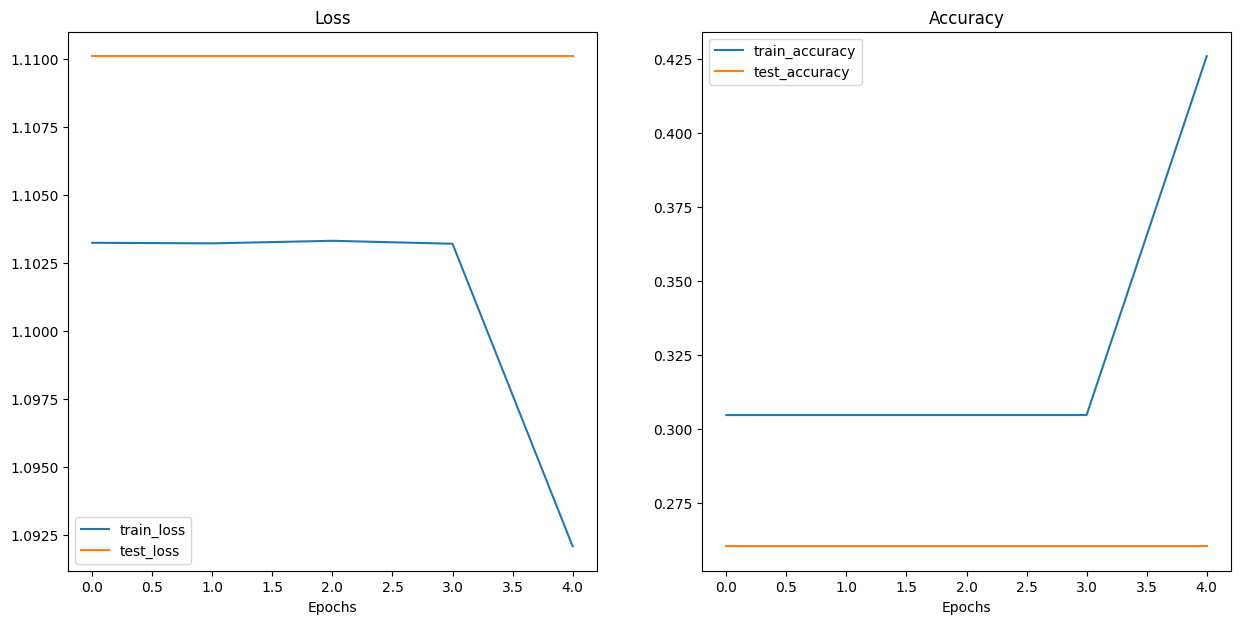

In [151]:
plot_loss_curves(model_0_results)

## Model_1: TinyVGG with data augmentation

In [152]:
from torchvision import transforms
train_transform_augmented=transforms.Compose([transforms.Resize(size=(64,64)),transforms.TrivialAugmentWide(num_magnitude_bins=31),transforms.ToTensor()])
test_transform_augmented=transforms.Compose([transforms.Resize(size=(64,64)),transforms.ToTensor()])

### Create train and test dataset and dataloaders

In [153]:
from torchvision.datasets import ImageFolder
train_data_aug=ImageFolder(root=train_dir,transform=train_transform_augmented,target_transform=None)
test_data_simple=ImageFolder(root=test_dir,transform=test_transform_augmented,target_transform=None)

In [154]:
from torch.utils.data import DataLoader
import os
train_dataloader_aug=DataLoader(dataset=train_data_aug,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_dataloader_aug=DataLoader(dataset=test_data_simple,batch_size=32,shuffle=False,num_workers=os.cpu_count())

### Construct and train model_1

In [155]:
torch.manual_seed(42)
model_1=TinyVGG(input=3,hidden_units=60,output=len(train_data_aug.classes)).to(device)
model_1

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=960, out_features=3, bias=True)
  )
)

In [156]:
lossfn=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(params=model_1.parameters(),lr=0.001)

In [157]:
model_1_results=train_and_test_model(model_1,5,train_dataloader_aug,test_dataloader_aug,lossfn,optimiser)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0999 | train_acc: 22.6562% | test_loss: 1.0941 | test_acc: 32.9545%
Epoch: 2 | train_loss: 1.0980 | train_acc: 34.3750% | test_loss: 1.0808 | test_acc: 50.2841%
Epoch: 3 | train_loss: 1.0919 | train_acc: 30.8594% | test_loss: 1.0752 | test_acc: 52.3674%
Epoch: 4 | train_loss: 1.0776 | train_acc: 32.0312% | test_loss: 1.0698 | test_acc: 40.3409%
Epoch: 5 | train_loss: 1.0461 | train_acc: 53.9062% | test_loss: 1.0728 | test_acc: 32.2917%
time_taken:47.31570475700005


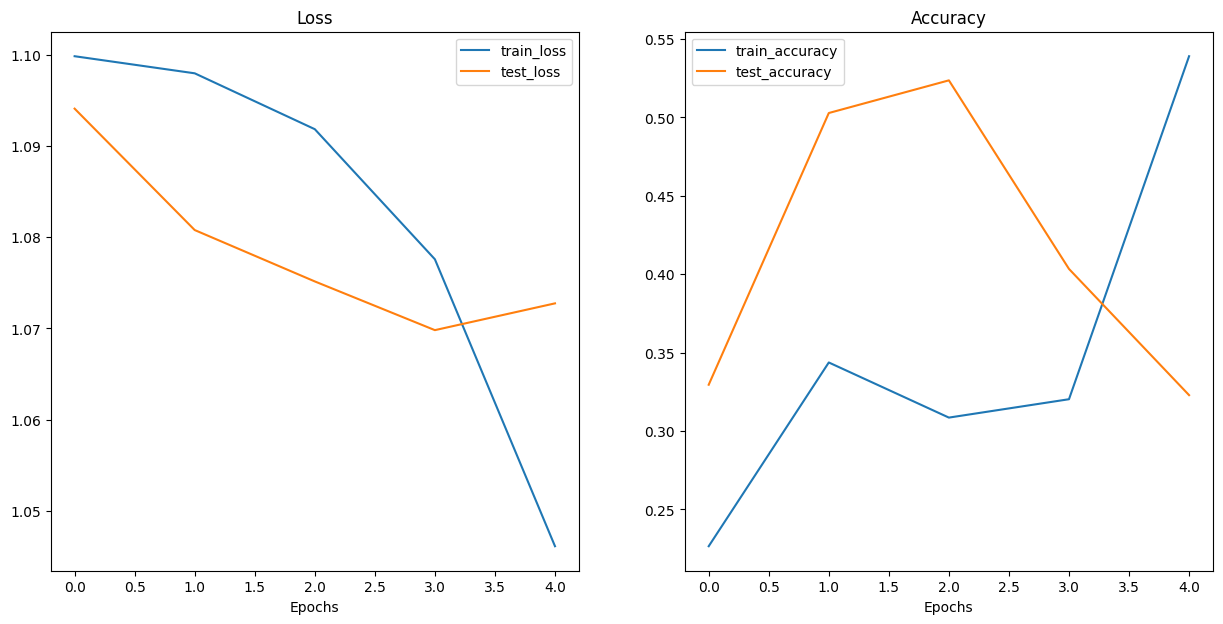

In [158]:
plot_loss_curves(model_1_results)

## Compare models results using `torch.tensorboard` and `wandb`

In [159]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.103239   0.304688   1.110102  0.260417
1    1.103218   0.304688   1.110102  0.260417
2    1.103312   0.304688   1.110102  0.260417
3    1.103204   0.304688   1.110102  0.260417
4    1.092077   0.425781   1.110102  0.260417

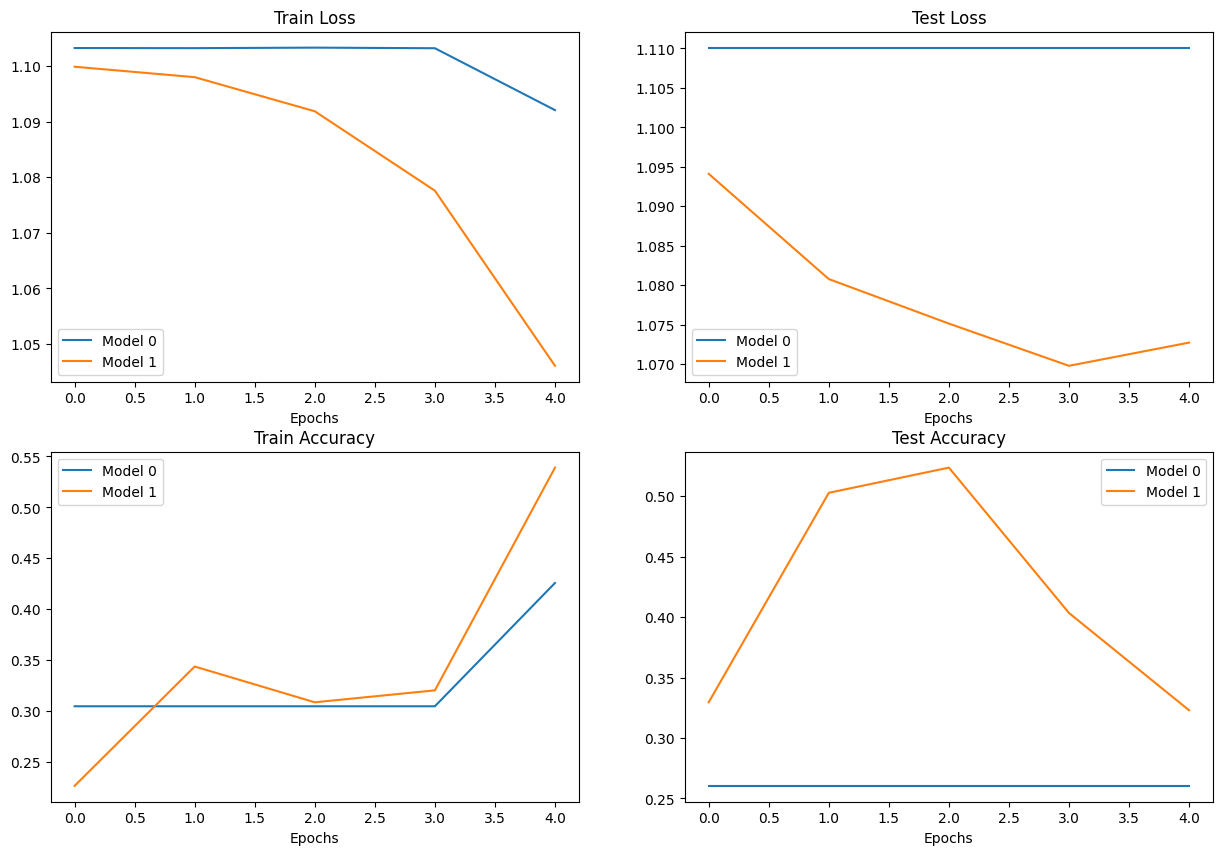

In [160]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Make predictions on a custom image

In [161]:
# download custom image
import requests

# get custom image path
custom_image_path= data_path/'custom.jpeg'
if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    print(f"downloading {custom_image_path}")
    request=requests.get('https://t3.ftcdn.net/jpg/00/27/57/96/360_F_27579652_tM7V4fZBBw8RLmZo0Bi8WhtO2EosTRFD.jpg')
    f.write(request.content)
    print(f"{custom_image_path} downloaded")
else:
  print(f"{custom_image_path} already exist")


data/custom.jpeg already exist


### Convert image into required format
- PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io.

- Since we want to load in an image, we'll use `torchvision.io.read_image()`.

- This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].
- the image must be converted into tensor,same shape,same data type,batchsize

In [162]:
import torchvision
custom8=torchvision.io.read_image(str(custom_image_path))

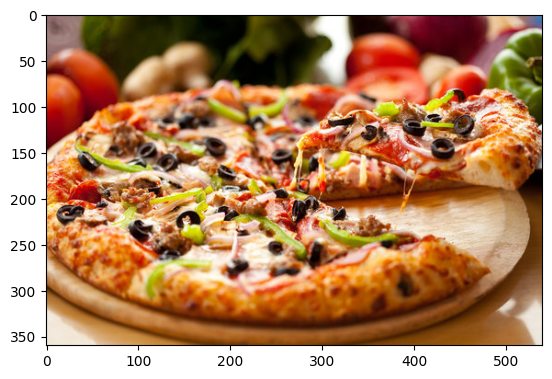

In [163]:
plt.imshow(custom8.permute(1,2,0))

In [164]:
#change datatype
print(f"before:{custom8.dtype}")
custom8=custom8.type(torch.float32)
print(f"after:{custom8.dtype}")

before:torch.uint8
after:torch.float32


In [165]:
#normalised tensor
print(f"before:{custom8[:1]}")
custom8=custom8/255
print(f"\nafter:{custom8[:1]}")

before:tensor([[[157., 156., 154.,  ...,  89.,  84.,  81.],
         [154., 154., 153.,  ...,  80.,  76.,  72.],
         [150., 150., 149.,  ...,  73.,  70.,  65.],
         ...,
         [242., 242., 242.,  ..., 237., 237., 237.],
         [241., 241., 241.,  ..., 236., 236., 236.],
         [240., 240., 240.,  ..., 236., 236., 236.]]])

after:tensor([[[0.6157, 0.6118, 0.6039,  ..., 0.3490, 0.3294, 0.3176],
         [0.6039, 0.6039, 0.6000,  ..., 0.3137, 0.2980, 0.2824],
         [0.5882, 0.5882, 0.5843,  ..., 0.2863, 0.2745, 0.2549],
         ...,
         [0.9490, 0.9490, 0.9490,  ..., 0.9294, 0.9294, 0.9294],
         [0.9451, 0.9451, 0.9451,  ..., 0.9255, 0.9255, 0.9255],
         [0.9412, 0.9412, 0.9412,  ..., 0.9255, 0.9255, 0.9255]]])


In [166]:
# change shape and add a batch and device
print(f"before:{custom8.shape}")
custom_image_transform=transforms.Compose([transforms.Resize(size=(64,64))])
custom8=custom_image_transform(custom8).unsqueeze(0).to(device)
print(f"after:{custom8.shape}")

before:torch.Size([3, 360, 540])
after:torch.Size([1, 3, 64, 64])


In [167]:
# make prediction

model_0.eval()
with torch.inference_mode():
  y_pred=model_0(custom8)
y_pred

tensor([[ 0.0442, -0.0176, -0.0480]])

In [168]:
y_probs=torch.softmax(y_pred,dim=1)
y_probs

tensor([[0.3506, 0.3296, 0.3198]])

In [169]:
y_class=torch.argmax(y_probs,dim=1)
class_names[y_class]

'pizza'

### Writing a function to predict and plot

In [170]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

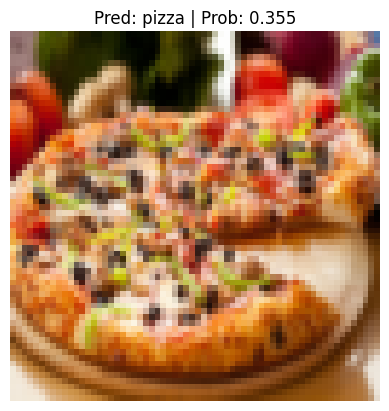

In [171]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)